# Simple ambit field example usage

This notebook shows how to use Python implementations for Algorithm 5 from Subsection 5.1 and Algorithm 7 from Appendix B.2 of https://arxiv.org/abs/2208.08784; figure 9 from the arxiv link have been created in the same way (check for the script). The full documentation can be found at https://danleonte.github.io/Ambit_Stochastics/index.html.
    
### Table of Contents

1. Simulation

    1.1. Slice  
    1.2. Cpp  
    
2. Parameter inference [to be updated]   
3. Forecasting  [to be added]

In [66]:
#module imports

%matplotlib inline
from ambit_stochastics.simple_ambit_field import simple_ambit_field
from ambit_stochastics.helpers.cov_estimator import compute_empirical_covariance_matrix
from scipy.integrate import quad
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
plt.style.use('ggplot')

## 1. Simulation

Consider a homogeneous Lévy basis $L$, a (potentially unbounded) set of finite area $A \subset \mathbb{R}^d$ and a collection of time and space-indexed sets $A_t(x)$ given by
\begin{equation*}
    A_t(x) = A + (t,\mathbf{x}),
\end{equation*}
where $\mathbf{x} \in \mathbb{R}^{d-1}$. For ease of presentation, assume $d=2$ and that $A$ is of the form 
\begin{equation*}
A = \{(s,x) \in \mathbb{R}^2 \colon  s<0, 0 < x < \phi(s) \},
\end{equation*}
where $\phi \colon (-\infty,0] \to \mathbb{R}_{\ge 0}$ is an increasing, convex and continuous function. We refer to $\phi$ as the ambit function and to $A$ as the ambit set. We aim to simulate the simple ambit field spatio-temporal process $$Y_t(x)= Y(t,x)=  L(A_t) = L(A + (t,x)).$$ 
We restrict our attention to simulating on a grid with step-sizes $\tau$ and $x$ on the temporal, respectively spatial axis. Thus we aim to simulate the simple ambit field $Y(t,x)$ at coordinates $\{(j\tau;ix) : 1 \le j \le k_t;1 \le i \le k_s\}$, where $k_t$ and $k_s$ are the number of translation on the temporal, respectively spatial axis.

### 1.1 Slice method

In [4]:
x= 0.25              #distance between translations of the ambit sets on the space axis
tau = 0.25           #distance between translations of the ambit sets on the time  axis
k_s = 50            #nr of ambit sets on the space axis
k_t = 50            #nr of ambit sets on the time axis
nr_simulations = 2   #nr of simulations

#### one bounded and one unbounded ambit set ####
ambit_function1 = lambda x :  (x>-1) * (x<=0) * (1+x) * 2 #vertical ambit set
ambit_function2 = lambda x : np.exp(x/5) * (x<=0)         #horizontal  ambit set

decorrelation_time1 = -1
decorrelation_time2 = -np.inf
#################################################
gaussian_part_params = (-3,7)
jump_part_params = (2,3)
jump_part_name   = 'gamma' #can be None,'cauchy','invgauss','poisson' (more to be implemented)
total_nr_samples = 10**7   #total nr of samples to be used in the slice estimation procedure, see Algorithm 4 from https://arxiv.org/abs/2208.08784
batch_size = 5* 10**4      #how many such samples to consider at once to prevent memory errors. not too important 



In [5]:
simple_ambit_field1 = simple_ambit_field(x = x , tau = tau, k_s = k_s, k_t = k_t, nr_simulations = nr_simulations,
                                ambit_function=ambit_function1, decorrelation_time=decorrelation_time1,
                                gaussian_part_params=gaussian_part_params, jump_part_name=jump_part_name,
                                jump_part_params=jump_part_params, batch_size=batch_size, total_nr_samples=total_nr_samples)

simple_ambit_field2 = simple_ambit_field(x = x , tau = tau, k_s = k_s, k_t = k_t, nr_simulations = nr_simulations,
                                ambit_function=ambit_function2, decorrelation_time=decorrelation_time2,
                                gaussian_part_params=gaussian_part_params, jump_part_name=jump_part_name,
                                jump_part_params=jump_part_params, batch_size=batch_size, total_nr_samples=total_nr_samples)

In [6]:
simple_ambit_field1.simulate()


Slice estimation procedure has started
Slice estimation procedure has finished
4.732897520065308
12.52% of points are used in the slice estimation


In [7]:
simple_ambit_field2.simulate()
#infinite decorrelation time takes longer. might be worth exploring a cython implementation

Slice estimation procedure has started
Slice estimation procedure has finished
40.906580686569214
25.0% of points are used in the slice estimation


In [12]:
#helper code for plotting simple ambit fields
def plot_simple_ambit_field(x,t,k_s,k_t,values,simulation_to_use):
    x0 = np.linspace(x, k_s * x, k_s)
    t0 = np.linspace(t, k_t * t, k_t)
    T0, X0 = np.meshgrid(t0, x0)

    plt.rcParams['axes.grid'] = False
    plt.contourf(T0, X0, values[simulation_to_use], 20, cmap='cividis')
    plt.colorbar();
    #plt.title('Simple ambit field')


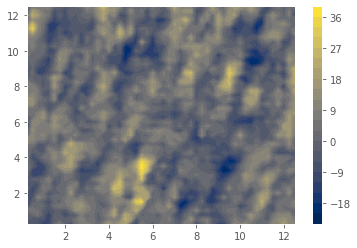

In [13]:
#plot of the first simple ambit field
#the value is given by the colour. note the vertical correlations.
#also see Figure 9 from https://arxiv.org/abs/2208.08784
plot_simple_ambit_field(x = x, t = tau, k_s = k_s, k_t = k_t, values = simple_ambit_field1.values, simulation_to_use = 1)

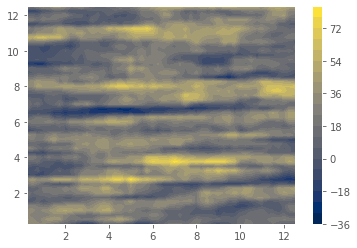

In [16]:
#plot of the second simple ambit field
#the value is given by the colour. note the horizontal correlations.
#also see Figure 9 from https://arxiv.org/abs/2208.08784plot_simple_ambit_field(x = x, t = tau, k_s = k_s, k_t = k_t, values = simple_ambit_field2.values, simulation_to_use = 1)
plot_simple_ambit_field(x = x, t = tau, k_s = k_s, k_t = k_t, values = simple_ambit_field2.values, simulation_to_use = 1)

In [153]:
#computes the empirical autocorrelation and autocovariance for each simulation
#the result has shape nr_simulation * max_lag_space * max_lag_time
empirical_cov1,empirical_cor1  =     compute_empirical_covariance_matrix(values=simple_ambit_field1.values,
                                                                  max_lag_space= 5,max_lag_time=4)

empirical_cov2,empirical_cor2  =     compute_empirical_covariance_matrix(values=simple_ambit_field2.values,
                                                                  max_lag_space= 15,max_lag_time=4)

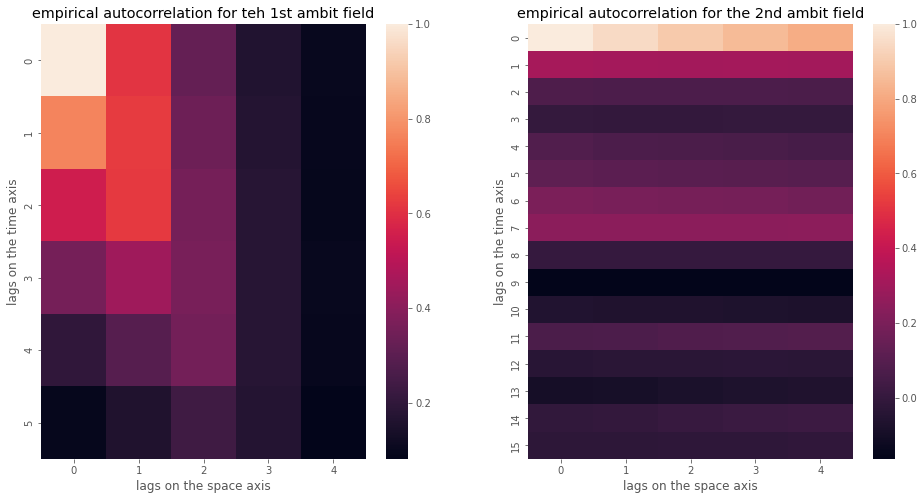

In [156]:
f,ax = plt.subplots(1,2,figsize = (16,8))

sns.heatmap(empirical_cor1[0], ax=ax[0])
ax[0].set_xlabel('lags on the space axis')
ax[0].set_ylabel('lags on the time axis')
_ = ax[0].set_title('empirical autocorrelation for teh 1st ambit field')

sns.heatmap(empirical_cor2[0], ax = ax[1])
ax[1].set_xlabel('lags on the space axis')
ax[1].set_ylabel('lags on the time axis')
_ = ax[1].set_title('empirical autocorrelation for the 2nd ambit field')

Note that the spatial correlations are much stronger for the 2nd ambit fields, which has a horizontal orientation (might help to draw the two ambit fields on paper)

In [125]:
empirical_cor2[0].shape

(11, 9)

In [146]:
empirical_cor2[1][:8,:2]

array([[ 1.        ,  0.94745908],
       [ 0.42906132,  0.43042665],
       [ 0.08238846,  0.07857401],
       [-0.04745114, -0.05728778],
       [-0.00822646, -0.00990741],
       [-0.03684352, -0.03515834],
       [-0.07248238, -0.06460201],
       [ 0.02401787,  0.02833419]])

In [132]:
empirical_cor2[0][0].shape

(9,)

In [152]:
empirical_cor2[0]

array([[ 1.00000000e+00,  9.48154194e-01,  8.98616654e-01,
         8.53866200e-01,  8.12393494e-01,  7.74923969e-01],
       [ 3.14649965e-01,  3.11279837e-01,  3.08903369e-01,
         3.09469622e-01,  3.08628665e-01,  3.08616307e-01],
       [ 7.35904656e-02,  6.98886930e-02,  7.01069093e-02,
         7.12735947e-02,  6.80991374e-02,  6.50586188e-02],
       [-3.02342683e-03, -6.41234547e-03, -5.73438145e-03,
        -2.15425443e-03, -9.23203046e-05,  6.57770017e-04],
       [ 8.23030982e-02,  7.23253745e-02,  6.60419593e-02,
         6.09681934e-02,  5.42001385e-02,  4.99515500e-02],
       [ 1.19449655e-01,  1.13327607e-01,  1.07708402e-01,
         1.02255809e-01,  9.80101625e-02,  9.52943670e-02],
       [ 2.00295680e-01,  1.95525751e-01,  1.90150462e-01,
         1.82498830e-01,  1.77465753e-01,  1.76078392e-01],
       [ 2.43793682e-01,  2.44749337e-01,  2.45372584e-01,
         2.44990757e-01,  2.48142902e-01,  2.53731740e-01],
       [ 1.73168066e-03,  6.84847801e-04,  1.028